# Churn Rate Telecom

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

__Servicios de Interconnect__

Interconnect proporciona principalmente dos tipos de servicios de comunicación:

1. `Teléfono fijo`. El teléfono se puede conectar a varias líneas de manera simultánea.
<br>

2. `Internet`. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*Protección De Dispositivo*) y un bloqueador de sitios web maliciosos (*Seguridad En Línea*).
- Línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*Backup Online*).
- Streaming de TV (*Streaming TV*) y directorio de películas (*Streaming Películas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

Para predecir la tasa de cancelación, se crean `modelos de clasificación` los cuales se comparan para elegir el mejor.

Como métrica principal para evaluar el modelo se usa el valor `AUC-ROC`, es decir el área bajo la curva característica operativa del receptor. Usada para medir el acierto en la predicción de eventos binarios.

Como métrica adicional se usa el valor de `exactitud`.

---

## Tabla de Contenido

1. **Plan de Trabajo**
2. **Inicialización del Proyecto**
3. **Preprocesamiento de Datos**
4. **Análisis Exploratorio de Datos (EDA)**
5. **Análisis de Correlación entre Variables**
6. **Preparación y Evaluación de Modelos**
   - Preparación de los Conjuntos de Datos
   - Función de Evaluación de Modelos
   - Modelos de Clasificación:
      - Logistic Regression
      - Decision Tree
      - Random Forest
      - LGBM Classifier
7. **Conclusiones**

---

## Plan de Trabajo

1. **Vista previa y preprocesamiento de datos**:

   - Cargar y examinar los datos.
   
   - Realizar una limpieza inicial y preprocesamiento (duplicados, nulos, outliers).
   
   <br>
2. **Análisis Exploratorio de Datos (EDA)**:

   - Explorar la distribución de variables clave, especialmente las que podrían influir en la cancelación.
   
   - Incluir una sección de correlación para analizar las relaciones entre las variables.
   
   <br>
3. **Adaptación de características para entrenamiento**:

   - Transformar variables categóricas a formato numérico, según lo requiera cada modelo de clasificación.
   
   <br>
   
4. **Entrenamiento de modelos predictivos**:

   - Separar los datos en conjuntos de entrenamiento y prueba, asegurando una representación adecuada de contratos cancelados en el conjunto de entrenamiento.
   
   - Entrenar múltiples modelos de clasificación, como regresión logística, árboles de decisión, bosque aleatorio, y LGBM Classifier.
   
   - Ajustar hiperparámetros para optimizar el rendimiento.
   <br>
   
5. **Evaluación y comparación de modelos**:

   - Evaluar cada modelo, utilizando el valor **AUC-ROC** como métrica principal y la **exactitud** como métrica secundaria.
   
   - Comparar los resultados y seleccionar el mejor modelo según los valores de estas métricas.
   <br>
   
---

## Descripción de los Datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;

- `personal.csv` — datos personales del cliente;

- `internet.csv` — información sobre los servicios de Internet;

- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

In [1]:
%%capture
%pip install catboost

<div class="alert alert-block alert-info">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Un truco aquí para cuando incluyas celdas que instalan nuevas librerías es que al inicio de la celda incluyas `%%capture` así todos los logs de la instalación no se visualizan
</div>

In [2]:
# Importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Cargar Datos y convertir a DataFrame
contract = pd.read_csv('/datasets/contract.csv')
personal = pd.read_csv('/datasets/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/phone.csv')

In [4]:
# Examinar estructura de dfs
for df in [contract, internet, personal, phone]:
  print(df.shape)

(7043, 8)
(5517, 8)
(7043, 5)
(6361, 2)


Se oberva que `contract` y `personal` tienen la misma cantidad de datos.

La diferencia en la cantidad de información, se debe probablemente a que no todos los usuarios cuentan con plan telefónico o  de internet y viceversa.

In [5]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [6]:
# Renombrar columnas
snake_contract = ['customer_id', 'begin_date','end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges']

contract.columns = snake_contract

<div class="alert alert-block alert-warning">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Cuando tengas columnas en este estilo, puedes optar por cambiarlas a snake case para que sea más acorde a como se trabaja en Python. Es decir, en lugar de EndDate, pasarlo a `end_date`
</div>

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>
Se ha solucionado el problema con el origen de las bases de datos.
</div>

In [7]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [8]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [9]:
# Renombrar columnas
snake_personal = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']

personal.columns = snake_personal

In [10]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
# Renombrar columnas
snake_internet = ['customer_id', 'internet_service', 'online_security', 'online_backup', 'device_protection',
                  'tech_support', 'streaming_tv', 'streaming_movies']

internet.columns = snake_internet

In [13]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [14]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [15]:
# Renombrar columnas
snake_phone = ['customer_id', 'multiple_lines']

phone.columns = snake_phone

In [16]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


<div class="alert alert-block alert-danger">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Cuando tengas datasets que tienen columnas con valores númericos siempre es ideal obtener métricas descriptivas de estas para que entiendas los datos con los que trabajarás utilizando `.describe()`. En este caso tienes algunas columnas cómo `mb_used`, `TotalCharge`, etc donde podrías aplicarlo. Para datasets que son cómo el que tienes en la variable `phone` no es necesario aplicar ese método porque no mostrará información útil
</div>

In [17]:
# Realizar el merge de los DataFrames usando 'customerID'
df = contract.merge(personal, on='customer_id', how='left') \
                       .merge(internet, on='customer_id', how='left') \
                       .merge(phone, on='customer_id', how='left')

# Verificar el resultado
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [18]:
# Información general del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

In [19]:
# Verificar existencia de duplicados
df['customer_id'].duplicated().sum()

0

In [20]:
# verificar existencia de valores nulos
df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

In [21]:
# Información estadística del DataFrame
df.describe()

,monthly_charges,senior_citizen
count,7043.000000,7043.000000
mean,64.761692,0.162147
std,30.090047,0.368612
min,18.250000,0.000000
25%,35.500000,0.000000
50%,70.350000,0.000000
75%,89.850000,0.000000
max,118.750000,1.000000


<div class="alert alert-block alert-success">
<b>Comentario del revisor (4ta Iteracion)</b> <a class=“tocSkip”></a>

Correcto, una muy buena exploración inicial para entender los datos
</div>

## Preprocesamiento de Datos

Chequearemos las inconsistencias por columnas, primero crearemos la columna objetivo considerando la columna `EndDate` cuando toma el valor `No`.

In [22]:
# Crear columna objetivo
df['churn'] = (df['end_date'] != "No").astype("int")
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,1


In [23]:
# Convertir las columnas begin_date y end_date a formato datetime
df['begin_date'] = pd.to_datetime(df['begin_date'], errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')

In [24]:
# Revisar filas con valor ausente en la columna total_charges
df[df['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,,Male,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,,Female,0,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,,Male,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,,Female,0,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,,Male,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,,Male,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,,Female,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,,Male,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,,Female,0,...,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


In [25]:
# Eliminar espacios con valores ausentes en la columna total_charges
df = df[df['total_charges'] != ' ']

# Cambiar columna TotalCharges a tipo float
df['total_charges'] = df['total_charges'].astype('float')

In [26]:
# Cambiar columnas a valores 0 y 1
yn_columns = ['paperless_billing', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'partner','dependents', 'multiple_lines']

# Asignar 1 a todos los usuarios que tengan cierto servicio y cambiar tipo de dato a int
for col in yn_columns:
  df.loc[df[col] == 'Yes', col] = 1
  df.loc[df[col] != 1, col] = 0

  df[col] = df[col].astype('int')

In [27]:
# Verificar categorías en la columna internet_service
df['internet_service'].value_counts(dropna=False)

# Rellenar valores nulos para la columna internet_service
df['internet_service'] = df['internet_service'].fillna('Unknown')

# Verificar cambios
df['internet_service'].unique()

array(['DSL', 'Fiber optic', 'Unknown'], dtype=object)

In [28]:
# Chequear la existencia de valores nulos
df.isnull().sum()

customer_id             0
begin_date              0
end_date             5163
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
multiple_lines          0
churn                   0
dtype: int64

No existen valores faltantes para las columnas. Eliminamos la columna `customer_id` dado que no contiene informacion relevante para la creación de modelos.

In [29]:
# Eliminar columnas innecesarias
df = df.drop('customer_id', axis=1)

## Análisis Exploratorio de Datos (EDA)

### Columnas Categóricas

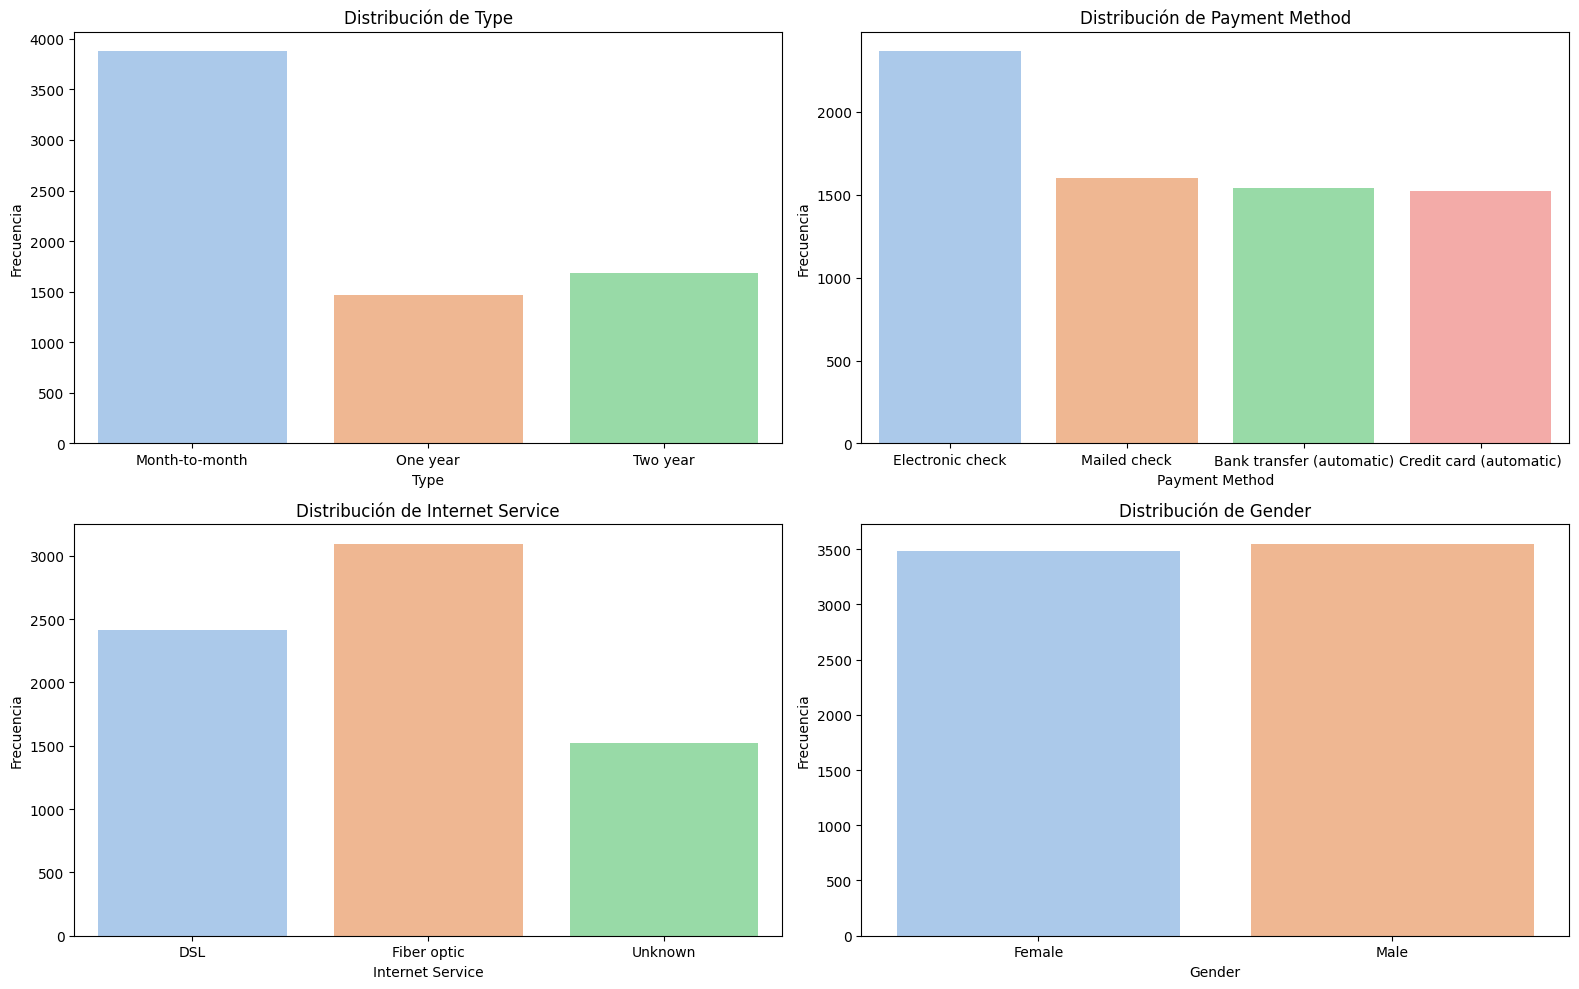

In [30]:
# Configurar el tamaño de la figura general
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Countplot para 'type'
sns.countplot(data=df, x='type', palette='pastel', ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Type')
axes[0, 0].set_xlabel('Type')
axes[0, 0].set_ylabel('Frecuencia')

# Countplot para 'payment_method'
sns.countplot(data=df, x='payment_method', palette='pastel', ax=axes[0, 1])
axes[0, 1].set_title('Distribución de Payment Method')
axes[0, 1].set_xlabel('Payment Method')
axes[0, 1].set_ylabel('Frecuencia')

# Countplot para 'internet_service'
sns.countplot(data=df, x='internet_service', palette='pastel', ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Internet Service')
axes[1, 0].set_xlabel('Internet Service')
axes[1, 0].set_ylabel('Frecuencia')

# Countplot para 'gender'
sns.countplot(data=df, x='gender', palette='pastel', ax=axes[1, 1])
axes[1, 1].set_title('Distribución de Gender')
axes[1, 1].set_xlabel('Gender')
axes[1, 1].set_ylabel('Frecuencia')

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

* `Type`: La mayoría de los clientes parecen preferir el contrato de mes a mes, mientras que una menor cantidad opta por contratos a largo plazo (de 1 o 2 años). Esto podría indicar que los clientes valoran la flexibilidad de los contratos mensuales o podrían estar menos comprometidos con la empresa, lo cual puede ser importante para la predicción de cancelación.

* `Payment Method`: El método de pago Electronic check es el más común entre los clientes, seguido por Mailed check, Bank transfer (automatic), y Credit card (automatic). Esto puede tener implicaciones en la retención de clientes, ya que el pago electrónico podría estar asociado a una mayor facilidad para cancelar el servicio.

* `Internet Service`: La mayoría de los clientes usa Fiber optic, mientras que un grupo significativo usa DSL. Un número más pequeño tiene un valor de servicio Unknown. La diferencia entre los tipos de servicio de Internet podría influir en la satisfacción del cliente y en la probabilidad de cancelación.

* `Gender` La distribución de género es bastante equilibrada entre Female y Male, lo cual sugiere que el género probablemente no sea un factor determinante por sí mismo en la tasa de cancelación, aunque podría ser considerado en combinación con otras variables.

### Columnas Numéricas

In [31]:
df[['monthly_charges', 'total_charges']].describe()

,monthly_charges,total_charges
count,7032.000000,7032.000000
mean,64.798208,2283.300441
std,30.085974,2266.771362
min,18.250000,18.800000
25%,35.587500,401.450000
50%,70.350000,1397.475000
75%,89.862500,3794.737500
max,118.750000,8684.800000


La alta variabilidad en los `total_charges` sugiere que algunos clientes han estado utilizando el servicio durante un largo período, mientras que otros son más recientes. Los clientes con cargos mensuales altos y cargos totales bajos podrían indicar aquellos que son nuevos y potencialmente más propensos a cancelar. Por otro lado, los clientes con cargos totales altos suelen ser de larga data y pueden tener mayor lealtad.

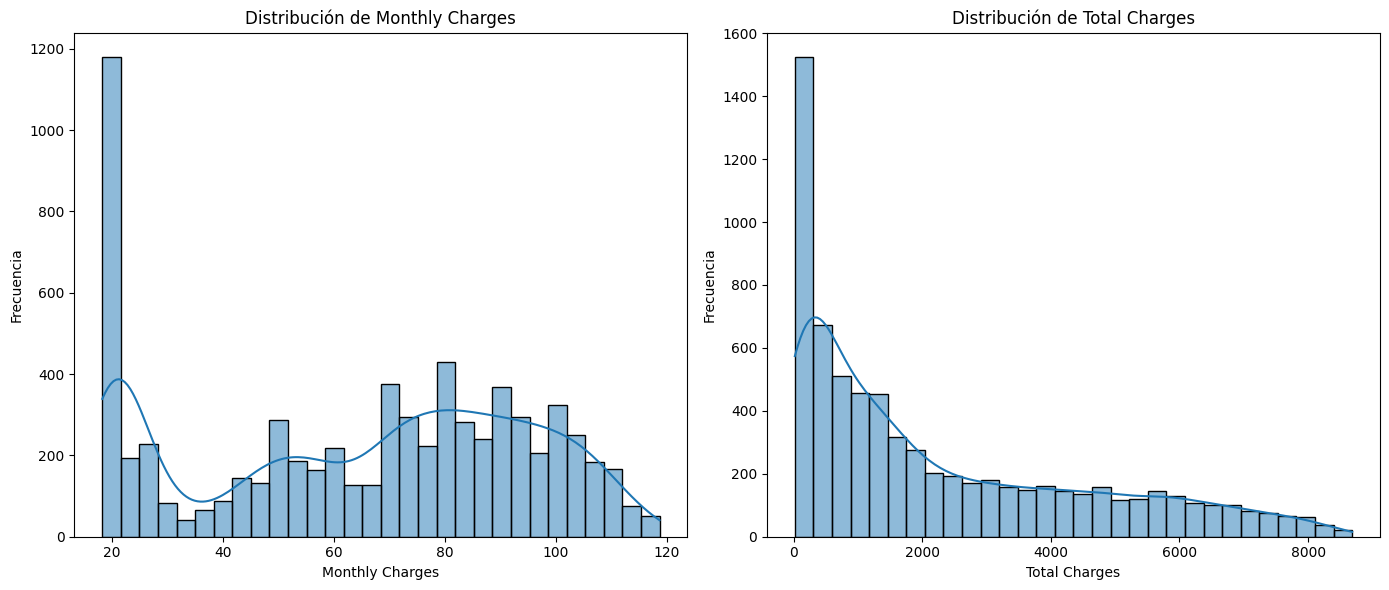

In [32]:
# Configurar el tamaño de las figuras
plt.figure(figsize=(14, 6))

# Gráfico de distribución para 'monthly_charges'
plt.subplot(1, 2, 1)
sns.histplot(df['monthly_charges'], bins=30, kde=True)
plt.title('Distribución de Monthly Charges')
plt.xlabel('Monthly Charges')
plt.ylabel('Frecuencia')

# Gráfico de distribución para 'total_charges'
plt.subplot(1, 2, 2)
sns.histplot(df['total_charges'], bins=30, kde=True)
plt.title('Distribución de Total Charges')
plt.xlabel('Total Charges')
plt.ylabel('Frecuencia')

# Ajustar el diseño y mostrar las gráficas
plt.tight_layout()
plt.show()

* La alta frecuencia de cargos mensuales bajos y totales cercanos a cero podría estar relacionada con clientes nuevos o de bajo compromiso, lo cual podría ser relevante en la predicción de cancelación.

* La variabilidad en `monthly_charges` indica la existencia de diferentes planes o combinaciones de servicios, lo cual también puede influir en la lealtad del cliente.

* La distribución sesgada de `total_charges` refuerza la idea de que muchos clientes tienen una relación reciente con la empresa, lo que puede aumentar el riesgo de cancelación.

## Variables Temporales

Vamos a verificar que las fechas esten en orden cronológico

In [33]:
# Establecer begin_date como indice
df.set_index(keys='begin_date', inplace=True)

# Comprobar que las fechas esten ordenadas
df.index.is_monotonic_increasing

False

In [34]:
# Ordenar Fechas
df = df.sort_values('begin_date')

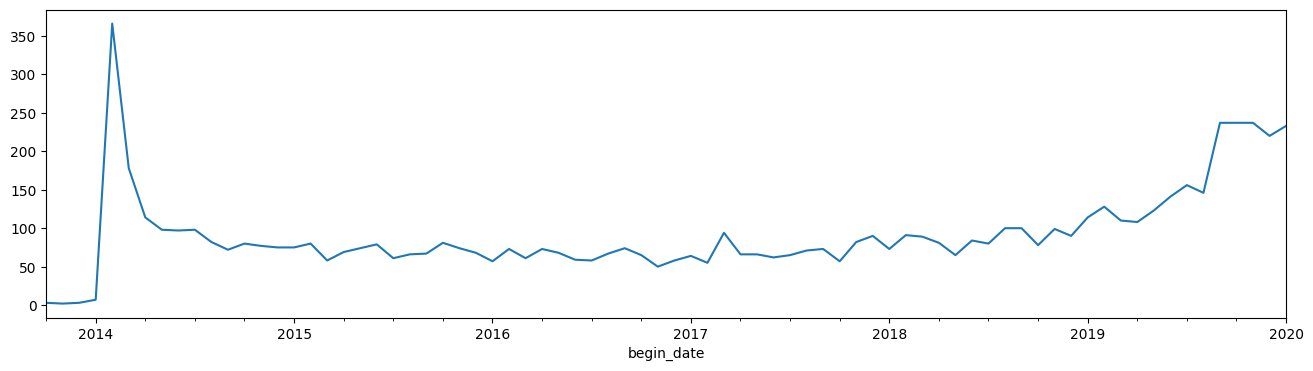

In [35]:
# Contrato de servicios por mes
df.resample('1M')['churn'].count().plot(figsize=(16,4))

plt.show()

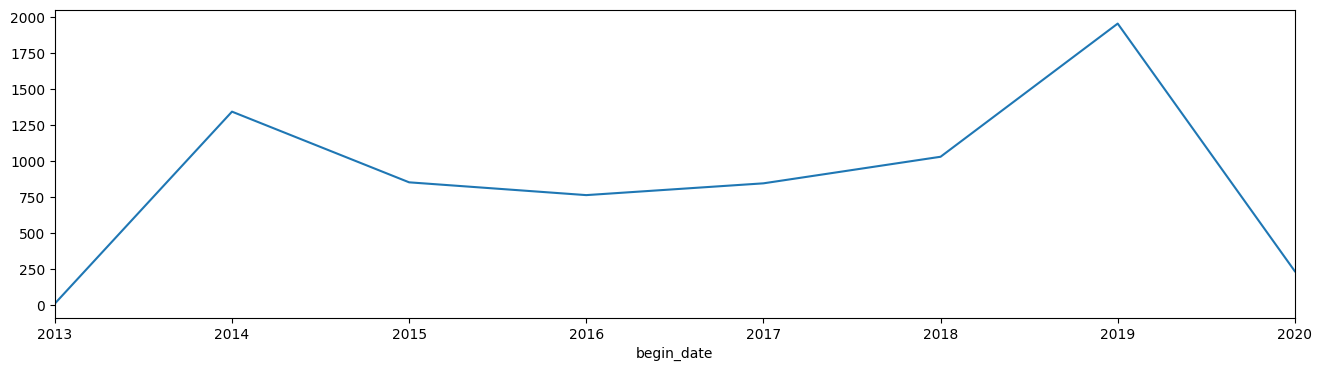

In [36]:
# Contrato de servicios por año
df.resample('1Y')['churn'].count().plot(figsize=(16,4))

plt.show()

Observamos un alto número de contratos el año 2014 y posteriormente se observa un peak cercano a los 2000 el año 2019.

In [37]:
#información de clientes dados de baja
end_date = df[df['end_date'] != 'No'].copy()
end_date['end_date'] = pd.to_datetime(end_date['end_date'])

In [38]:
#cancelaciones del contrato por fecha
end_date['end_date'].describe()

count                    1869
unique                      4
top       2019-11-01 00:00:00
freq                      485
first     2019-10-01 00:00:00
last      2020-01-01 00:00:00
Name: end_date, dtype: object

Observamos fechas de inicio de contratos desde el 1 de octubre de 2013, hasta el 1 de enero 2020. Sin embargo, existen fechas de cancelaciones desde el 1 de octubre de 2019 hasta el 1 de enero 2020.

In [39]:
# Establecer end_date como indice
end_date.set_index(keys='end_date', inplace=True)

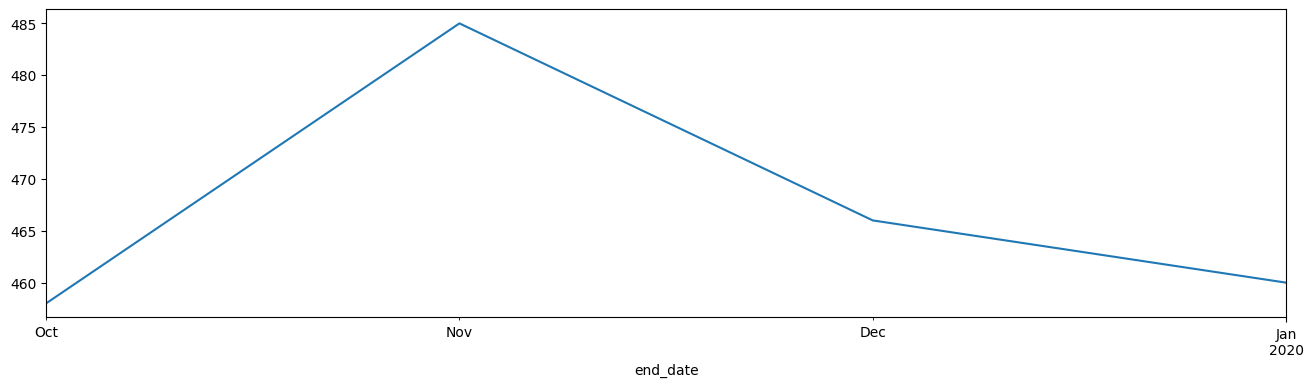

In [40]:
# Cancelaciones por mes
end_date.resample('1M')['churn'].sum().plot(figsize=(16,4))
plt.xlim()
plt.show()

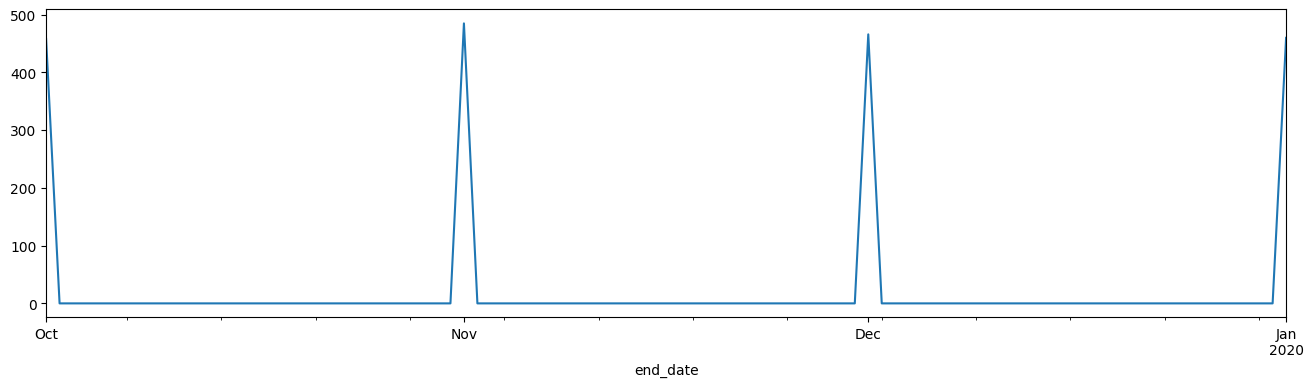

In [41]:
# Cancelaciones por dia
end_date.resample('1D')['churn'].sum().plot(figsize=(16,4))
plt.xlim()
plt.show()

Las cancelaciones iniciaron en octubre del 2019, incrementaron durante noviembre y disminuyeron nuevamente en diciembre.

Solo hay registro de cancelaciones al cambiar el mes, probablemente cerca de la fecha de cobro.

## Correlación de variables

## Correlación de variables númericas

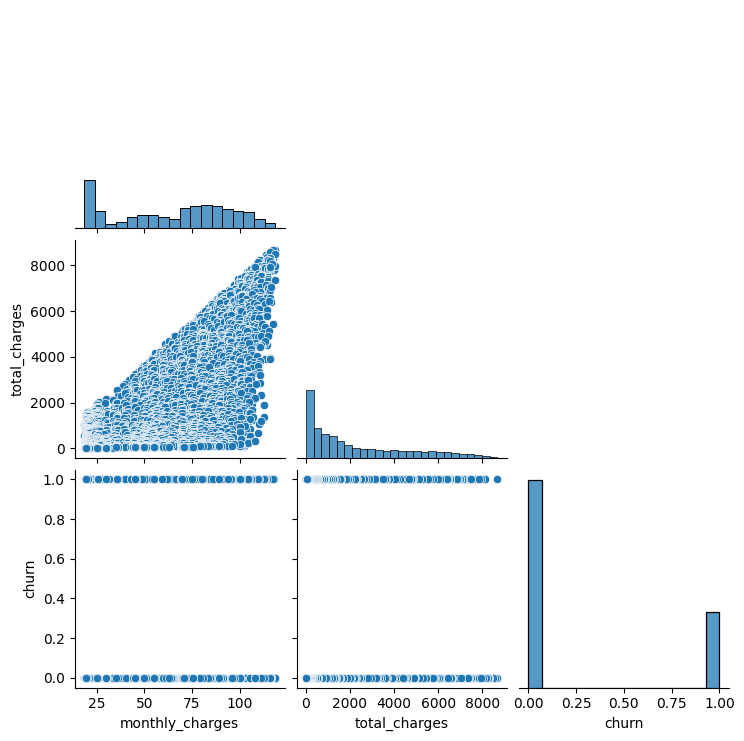

In [42]:
# Matriz de dispersión
sns.pairplot(df[['monthly_charges', 'total_charges', 'churn']], corner=True)

plt.show()

In [43]:
# Matriz de correlación para características numéricas
df[['monthly_charges', 'total_charges', 'churn']].corr()

,monthly_charges,total_charges,churn
monthly_charges,1.000000,0.651065,0.192858
total_charges,0.651065,1.000000,-0.199484
churn,0.192858,-0.199484,1.000000


Esto muestra que hay una relación moderadamente positiva entre la columna `monthly_charges` y la variable objetivo. Por otro lado, observamos una relacion negativa leve de la columna `total_charges` y la variable objetivo.

## Correlación para variables booleanas

In [44]:
# Columnas Booleanas
bool_col = ['paperless_billing', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'senior_citizen', 'partner', 'dependents', 'multiple_lines']

# Agregamos la variable objetivo
bool_col.append('churn')

# Matriz de correlación para características booleanas
df[bool_col].corr()['churn'].sort_values()


online_security     -0.171270
tech_support        -0.164716
dependents          -0.163128
partner             -0.149982
online_backup       -0.082307
device_protection   -0.066193
multiple_lines       0.040033
streaming_movies     0.060860
streaming_tv         0.063254
senior_citizen       0.150541
paperless_billing    0.191454
churn                1.000000
Name: churn, dtype: float64

Vemos que existe una relación negativa de la columna objetivo con las columnas:

- `online_security`
- `tech_support`
- `dependents`
- `partner`

Además, observamos una relación positiva de la columna objetivo con las columnas:

- `paperless_billing`
- `senior_citizen`

Hay una relación casi nula (menor a 0.10 absoluto) de la columna objetivo con el resto de las columnas.

## Preparación y Evaluación de Modelos

## Preparar el conjunto de datos

En las columnas `payment_method` y `type` se agrupan las categorías que son similares, considerando la tasa de cancelación.

In [45]:
# Agrupar las categorías de la columna payment_method
df.loc[df['payment_method'] != 'Electronic check', 'payment_method'] = 'Other'

# Verificar valores únicos en la columna 'payment_method'
df['payment_method'].unique()

array(['Other', 'Electronic check'], dtype=object)

In [46]:
# Agrupar categorías de la columna 'type'
df.loc[df['type'] != 'Month-to-month', 'type'] = '1 year or more'

# Verificar valores únicos en la columna 'type'
df['type'].unique()

array(['1 year or more', 'Month-to-month'], dtype=object)

Eliminamos las columnas que no son relevantes para el entrenamiento del modelo como la columna `gender` que no muestra influencia sobre la variable objetivo y la columna `end_date` que forma parte de la variable objetivo.

In [47]:
# Eliminar características para entrenar al modelo
df = df.drop(columns=['gender', 'end_date'])

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7032 entries, 2013-10-01 to 2020-01-01
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   int64  
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float64
 5   senior_citizen     7032 non-null   int64  
 6   partner            7032 non-null   int64  
 7   dependents         7032 non-null   int64  
 8   internet_service   7032 non-null   object 
 9   online_security    7032 non-null   int64  
 10  online_backup      7032 non-null   int64  
 11  device_protection  7032 non-null   int64  
 12  tech_support       7032 non-null   int64  
 13  streaming_tv       7032 non-null   int64  
 14  streaming_movies   7032 non-null   int64  
 15  multiple_lines     7032 non-null   int64  
 16  churn 

In [49]:
# Aplicar get_dummies a las columnas categóricas 'type', 'payment_method' e 'internet_service'
df = pd.get_dummies(df, columns=['type', 'payment_method', 'internet_service'], drop_first=True)

In [50]:
# Inicializar el escalador
scaler = StandardScaler()

# Seleccionar las columnas a escalar
columns_to_scale = ['monthly_charges', 'total_charges']

# Ajustar y transformar los datos en las columnas seleccionadas
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Verificar los resultados
print(df.head())

            paperless_billing  monthly_charges  total_charges  senior_citizen  \
begin_date                                                                      
2013-10-01                  0         0.919158       1.833994               1   
2013-10-01                  1         1.761803       2.824261               0   
2013-10-01                  1         1.308071       2.385346               1   
2013-11-01                  1         1.437709       2.315727               0   
2013-11-01                  1         1.455991       2.385765               0   

            partner  dependents  online_security  online_backup  \
begin_date                                                        
2013-10-01        1           1                1              1   
2013-10-01        1           0                1              1   
2013-10-01        1           0                0              1   
2013-11-01        0           0                1              0   
2013-11-01        1           

In [51]:
df['churn'].value_counts()

0    5163
1    1869
Name: churn, dtype: int64

## Division del conjunto de datos

In [52]:
from sklearn.utils import resample

# Separar las características de la variable objetivo
X = df.drop(['churn'], axis=1)
y = df['churn']

# Dividir los datos en entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# Aplicar upsampling al conjunto de entrenamiento
X_train_minority = X_train[y_train == 1]
y_train_minority = y_train[y_train == 1]
X_train_majority = X_train[y_train == 0]
y_train_majority = y_train[y_train == 0]

X_train_minority_upsampled = resample(X_train_minority,
                                      replace=True,
                                      n_samples=len(X_train_majority),
                                      random_state=42)
y_train_minority_upsampled = resample(y_train_minority,
                                      replace=True,
                                      n_samples=len(y_train_majority),
                                      random_state=42)

# Combinar las clases mayoritaria y minoritaria upsampleada
X_train_resampled = pd.concat([X_train_majority, X_train_minority_upsampled])
y_train_resampled = pd.concat([y_train_majority, y_train_minority_upsampled])

# Verificar las distribuciones de las clases después del balanceo
print("Distribución de clases antes del upsampling:", y_train.value_counts())
print("Distribución de clases después del upsampling:", y_train_resampled.value_counts())

Distribución de clases antes del upsampling: 0    3058
1    1125
Name: churn, dtype: int64
Distribución de clases después del upsampling: 0    3058
1    3058
Name: churn, dtype: int64


## Función de Evaluación de Modelos

In [53]:
def train_and_evaluate_models(X_train, y_train, X_val, y_val):
    # Inicializar los modelos
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "LGBM Classifier": LGBMClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "CatBoost Classifier": CatBoostClassifier(random_state=42, verbose=0)
    }

    # Diccionario para almacenar los resultados
    results = {
        "Model": [],
        "AUC-ROC": [],
        "Accuracy": [],
        "F1-Score": [],
        "Training Time (s)": []
    }

    # Graficar la curva ROC
    plt.figure(figsize=(10, 8))

    # Entrenar y evaluar cada modelo
    for model_name, model in models.items():
        start_time = time.time()  # Registrar el tiempo de inicio
        
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        end_time = time.time()  # Registrar el tiempo de finalización
        training_time = round(end_time - start_time, 2)  # Calcular el tiempo de entrenamiento

        # Realizar predicciones en el conjunto de validación
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilidades para la clase positiva

        # Calcular métricas
        auc = round(roc_auc_score(y_val, y_pred_proba), 2)
        accuracy = round(accuracy_score(y_val, y_pred), 2)
        f1 = round(f1_score(y_val, y_pred), 2)

        # Guardar los resultados
        results["Model"].append(model_name)
        results["AUC-ROC"].append(auc)
        results["Accuracy"].append(accuracy)
        results["F1-Score"].append(f1)
        results["Training Time (s)"].append(training_time)

        # Curva ROC
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

    # Configurar la gráfica de la curva ROC
    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.show()

    # Convertir los resultados en un DataFrame para facilitar la visualización
    results_df = pd.DataFrame(results)

    return results_df

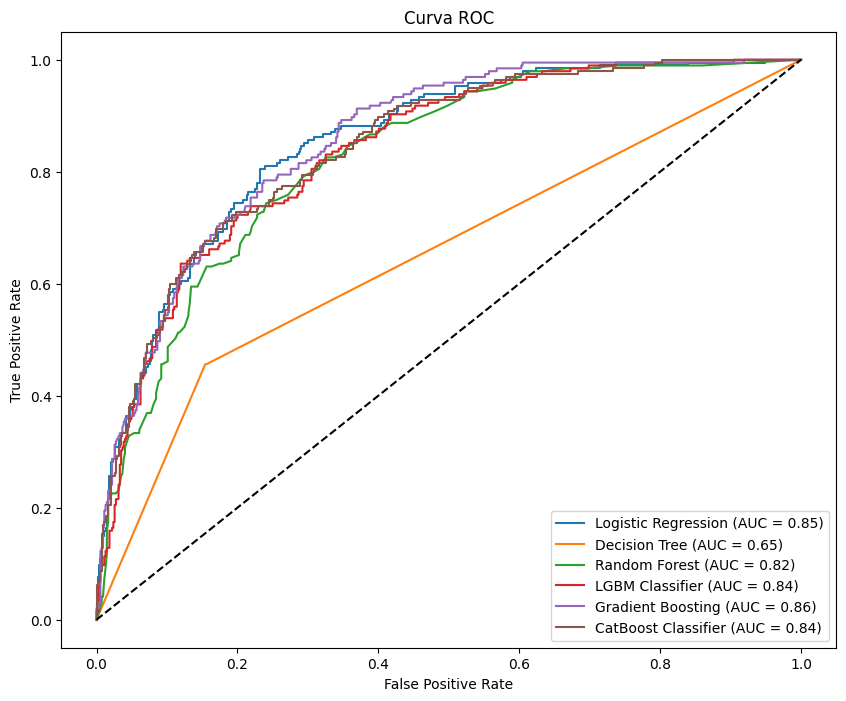

,Model,AUC-ROC,Accuracy,F1-Score,Training Time (s)
0,Logistic Regression,0.85,0.76,0.64,0.02
1,Decision Tree,0.65,0.74,0.48,0.09
2,Random Forest,0.82,0.79,0.60,0.47
3,LGBM Classifier,0.84,0.78,0.63,0.29
4,Gradient Boosting,0.86,0.75,0.63,0.56
5,CatBoost Classifier,0.84,0.77,0.63,1.88


In [54]:
results_df = train_and_evaluate_models(X_train_resampled, y_train_resampled, X_val, y_val)

results_df

* `Logistic Regression` y `Gradient Boosting` destacan como los mejores modelos en general, con un buen balance entre `AUC-ROC`, `Accuracy` y `F1-Score`.

* `Random Forest` tiene la mejor `Accuracy`, pero un `F1-Score` ligeramente menor, lo cual podría indicar que es menos balanceado al predecir ambas clases.

* `Decision Tree` parece ser el modelo menos efectivo en general, debido a sus bajos valores de `AUC-ROC` y `F1-Score`.

## Ajuste de Hiperparametros

In [57]:
def train_and_evaluate_models_with_hyperparameters(X_train, y_train, X_val, y_val, X_test, y_test):
    # Definir los modelos y sus hiperparámetros para ajuste
    models = {
        "Logistic Regression": (LogisticRegression(max_iter=1000, random_state=42),
                                {'C': [0.01, 0.1, 1, 10]}),

        "Decision Tree": (DecisionTreeClassifier(random_state=42),
                          {'max_depth': [None, 5, 10, 20], 'min_samples_split': [2, 5, 7]}),

        "Random Forest": (RandomForestClassifier(random_state=42),
                          {'n_estimators': [50, 100, 200], 'max_features': ['sqrt', 'log2'], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 7]}),

        "CatBoost Classifier": (CatBoostClassifier(random_state=42, verbose=0),
                                {'iterations': [10, 30, 50, 100], 'learning_rate': [0.5, 0.1, 0.01], 'depth': [4, 6, 8, 10]}),

        "Gradient Boosting": (GradientBoostingClassifier(random_state=42),
                              {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}),

        "LGBM Classifier": (LGBMClassifier(random_state=42),
                            {'num_leaves': [31, 50], 'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]})
    }

    # Diccionario para almacenar los resultados
    results = {
        "Model": [],
        "Best Params": [],
        "Training Time (s)": [],
        "Prediction Time (s)": [],
        "Train AUC-ROC": [],
        "Test AUC-ROC": [],
        "Validation AUC-ROC": [],
        "Train Accuracy": [],
        "Test Accuracy": [],
        "Validation Accuracy": []
    }

    # Graficar la curva ROC en el conjunto de validación
    plt.figure(figsize=(10, 8))

    # Entrenar y evaluar cada modelo con ajuste de hiperparámetros
    for model_name, (model, params) in models.items():
        start_time = time.time()  # Tiempo de inicio de entrenamiento
        grid_search = GridSearchCV(model, params, cv=3, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        training_time = round(time.time() - start_time, 2)  # Tiempo de entrenamiento

        best_model = grid_search.best_estimator_

        # Medir el tiempo de predicción
        start_pred_time = time.time()
        y_train_proba = best_model.predict_proba(X_train)[:, 1]
        y_val_proba = best_model.predict_proba(X_val)[:, 1]
        y_test_proba = best_model.predict_proba(X_test)[:, 1]
        pred_time = round(time.time() - start_pred_time, 2)  # Tiempo de predicción

        y_train_pred = best_model.predict(X_train)
        y_val_pred = best_model.predict(X_val)
        y_test_pred = best_model.predict(X_test)

        # Calcular métricas AUC-ROC y Accuracy en cada conjunto
        train_auc = round(roc_auc_score(y_train, y_train_proba), 4)
        val_auc = round(roc_auc_score(y_val, y_val_proba), 4)
        test_auc = round(roc_auc_score(y_test, y_test_proba), 4)

        train_accuracy = round(accuracy_score(y_train, y_train_pred), 4)
        val_accuracy = round(accuracy_score(y_val, y_val_pred), 4)
        test_accuracy = round(accuracy_score(y_test, y_test_pred), 4)

        # Guardar los resultados
        results["Model"].append(model_name)
        results["Best Params"].append(grid_search.best_params_)
        results["Training Time (s)"].append(training_time)
        results["Prediction Time (s)"].append(pred_time)
        results["Train AUC-ROC"].append(train_auc)
        results["Test AUC-ROC"].append(test_auc)
        results["Validation AUC-ROC"].append(val_auc)
        results["Train Accuracy"].append(train_accuracy)
        results["Test Accuracy"].append(test_accuracy)
        results["Validation Accuracy"].append(val_accuracy)

        # Curva ROC en el conjunto de validación
        fpr, tpr, _ = roc_curve(y_val, y_val_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {val_auc:.2f})')

    # Configurar la gráfica de la curva ROC
    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC en el Conjunto de Validación')
    plt.legend(loc='lower right')
    plt.show()

    # Convertir los resultados en un DataFrame para facilitar la visualización
    results_df = pd.DataFrame(results)

    return results_df


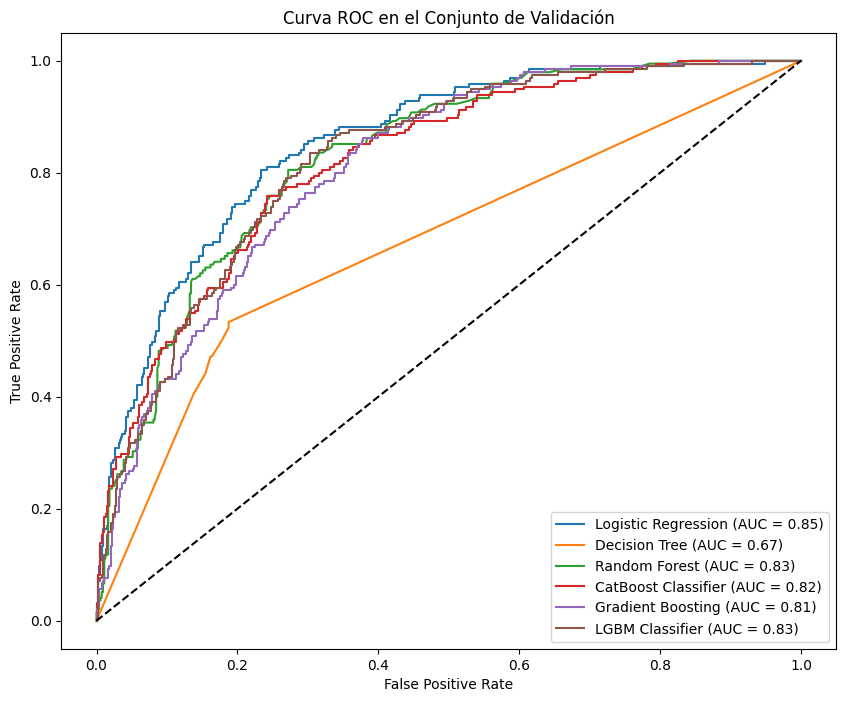

In [58]:
# Ejemplo de uso
results_df = train_and_evaluate_models_with_hyperparameters(X_train_resampled, y_train_resampled, X_val, y_val, X_test, y_test)

In [59]:
results_df

,Model,Best Params,Training Time (s),Prediction Time (s),Train AUC-ROC,Test AUC-ROC,Validation AUC-ROC,Train Accuracy,Test Accuracy,Validation Accuracy
0,Logistic Regression,{'C': 10},1.94,0.01,0.8435,0.8314,0.8537,0.7637,0.7488,0.7618
1,Decision Tree,"{'max_depth': None, 'min_samples_split': 5}",0.62,0.01,0.9990,0.6606,0.6739,0.9807,0.7427,0.7402
2,Random Forest,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",60.82,0.25,1.0000,0.8108,0.8294,0.9969,0.7853,0.7943
3,CatBoost Classifier,"{'depth': 10, 'iterations': 100, 'learning_rat...",43.13,0.01,0.9902,0.8120,0.8213,0.9529,0.7673,0.7618
4,Gradient Boosting,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti...",62.48,0.04,1.0000,0.8085,0.8108,0.9975,0.7825,0.7605
5,LGBM Classifier,"{'learning_rate': 0.2, 'n_estimators': 200, 'n...",329.32,0.19,0.9998,0.8027,0.8253,0.9918,0.7687,0.7740


## Conclusión y Recomendación

### Modelos de Machine Learning

1. **Random Forest** y **Gradient Boosting**:

   - Estos modelos presentan los mejores resultados en términos de `AUC-ROC` en los conjuntos de prueba y validación, lo que indica un excelente equilibrio entre discriminación y generalización.
   
   - Sin embargo, tienen tiempos de entrenamiento relativamente largos, lo que puede ser un factor a considerar si se necesita una solución más rápida.
   

2. **Logistic Regression**:

   - Demuestra un rendimiento consistente entre los conjuntos de datos y tiene tiempos de entrenamiento y predicción muy cortos. 
   
   - Es una opción robusta y simple, ideal para implementaciones donde la rapidez es clave y se desea evitar la complejidad innecesaria.
   

3. **Decision Tree**:

   - Presenta un tiempo de entrenamiento rápido, pero sufre de sobreajuste significativo, lo que se refleja en una caída considerable en el `AUC-ROC` del conjunto de validación y prueba.
   
   - No es recomendable para aplicaciones que buscan una buena capacidad de generalización.
   

4. **CatBoost Classifier**:

   - Ofrece un buen rendimiento con un `AUC-ROC` alto y tiempos de entrenamiento y predicción razonables. 
   
   - Aunque presenta cierto sobreajuste, sigue siendo una opción viable para aplicaciones que requieren alta capacidad predictiva y tiempos de inferencia rápidos.
   

5. **LGBM Classifier**:

   - Tiene un tiempo de entrenamiento significativamente más alto, pero su rendimiento es competitivo.
   
   - Esto podría ser una desventaja en entornos donde el tiempo de entrenamiento es crítico, pero sigue siendo una opción para casos donde la precisión es prioritaria.

### Recomendaciones:

- **Random Forest** y **Gradient Boosting** son ideales para implementaciones en producción que puedan manejar tiempos de entrenamiento más largos y buscan alta precisión.


- **Logistic Regression** es adecuada para proyectos donde se valora la simplicidad, la velocidad de entrenamiento/predicción y un rendimiento consistente.


- **CatBoost Classifier** es una opción intermedia con un buen rendimiento y tiempos de entrenamiento razonables.


- **LGBM Classifier** es apropiado en contextos donde el tiempo de entrenamiento no es una limitación, pero se busca alta precisión.